# Task 3c – CRM Dashboard Visualizations

I implemented the four visualizations required by tasl 3c:

1. Pipeline Value by Deal Stage: A bar chart showing total deal value grouped by deal_stage.

2. Revenue by Industry/Sector (Closed Won only): A bar chart showing revenue distribution by industry/sector using only Closed Won deals.

3. Lead Conversion Rate: A simple “Converted vs Not Converted” chart based on whether a deal stage includes “Won”.

4. Deal Amount Distribution: A histogram showing how deal sizes are distributed across the dataset.

Additional Features Implemented:
- A reusable apply_filters() function to filter by:
    - Account
    - Sales agent
    - Minimum engagement date
- A unified show_chart() function that renders any visualization based on a selected chart type.

These functions match the logic used in our team’s Gradio interface so that the charts can later be displayed directly in the CRM UI.

### 1. Imports & Data Loading

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Slightly change chart style
sns.set(style="whitegrid")

base_path = os.path.abspath("../data_directory/clean_data")

# Read the data
pipeline = pd.read_csv(os.path.join(base_path, "Pipeline.csv"))
accounts = pd.read_csv(os.path.join(base_path, "Accounts.csv"))
teams = pd.read_csv(os.path.join(base_path, "Teams.csv"))
products = pd.read_csv(os.path.join(base_path, "Products.csv"))

pipeline.head()

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value
0,1c1i7a6r,moses_frase,gtx_plus_basic,cancity,won,2016-10-20,2017-03-01,1054.0
1,z063oyw0,darcel_schlecht,gtxpro,isdom,won,2016-10-25,2017-03-11,4514.0
2,ec4qe1bx,darcel_schlecht,mg_special,cancity,won,2016-10-25,2017-03-07,50.0
3,mv1lwrnh,moses_frase,gtx_basic,codehow,won,2016-10-25,2017-03-09,588.0
4,pe84cx4o,zane_levy,gtx_basic,hatfan,won,2016-10-25,2017-03-02,517.0


### 2. Inspect Data

In [7]:
print("Pipeline columns:", pipeline.columns.tolist())
print("Accounts columns:", accounts.columns.tolist())

pipeline.info()
accounts.info()


Pipeline columns: ['opportunity_id', 'sales_agent', 'product', 'account', 'deal_stage', 'engage_date', 'close_date', 'close_value']
Accounts columns: ['account', 'sector', 'year_established', 'revenue', 'employees', 'office_location', 'subsidiary_of']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   opportunity_id  8800 non-null   object 
 1   sales_agent     8800 non-null   object 
 2   product         8800 non-null   object 
 3   account         8800 non-null   object 
 4   deal_stage      8800 non-null   object 
 5   engage_date     8300 non-null   object 
 6   close_date      6711 non-null   object 
 7   close_value     8800 non-null   float64
dtypes: float64(1), object(7)
memory usage: 550.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 7 columns):
 #   Column            Non-Null Coun

### 3. Helper Function — Apply Filters

In [8]:
def apply_filters(df, account=None, agent=None, timeframe=None):
    data = df.copy()
    
    # Account filter
    if account:
        data = data[data["account"] == account]
    
    # Sales agent filter
    if agent:
        data = data[data["sales_agent"] == agent]
    
    # Timeframe filter
    if timeframe:
        try:
            data["engage_date"] = pd.to_datetime(data["engage_date"])
            data = data[data["engage_date"] >= pd.to_datetime(timeframe)]
        except:
            print("⚠️ Invalid date format. Use YYYY-MM-DD.")
    
    return data


### 4. Chart 1 — Pipeline Value by Deal Stage

In [9]:
def plot_pipeline_by_stage(pipeline_df):
    if pipeline_df.empty:
        print("No data for the selected filters.")
        return
    
    summary = pipeline_df.groupby("deal_stage")["close_value"].sum().sort_values()
    
    plt.figure(figsize=(10, 6))
    summary.plot(kind="bar")
    plt.title("Pipeline Value by Deal Stage")
    plt.xlabel("Deal Stage")
    plt.ylabel("Total Deal Value ($)")
    plt.xticks(rotation=45)
    plt.show()


### 5. Chart 2 — Revenue by Industry

In [10]:
def plot_revenue_by_industry(pipeline_df, accounts_df):
    if pipeline_df.empty:
        print("No data for the selected filters.")
        return

    # Join pipeline with accounts to get industry field
    merged = pipeline_df.merge(accounts_df, on="account", how="left")

    # Keep only Closed Won deals for real revenue
    won = merged[merged["deal_stage"].str.contains("Closed Won", case=False, na=False)]

    if won.empty:
        print("No Closed Won (revenue) data.")
        return

    revenue = won.groupby("industry")["close_value"].sum().sort_values()

    plt.figure(figsize=(10, 6))
    revenue.plot(kind="bar")
    plt.title("Revenue by Industry (Closed Won Only)")
    plt.xlabel("Industry")
    plt.ylabel("Revenue ($)")
    plt.xticks(rotation=45)
    plt.show()


### 6. Chart 3 — Lead Conversion Rate

In [11]:
def plot_conversion_rate(pipeline_df):
    if pipeline_df.empty:
        print("No data for the selected filters.")
        return
    
    pipeline_df = pipeline_df.copy()
    pipeline_df["converted"] = pipeline_df["deal_stage"].str.contains("Closed Won", case=False, na=False)

    conv_counts = pipeline_df["converted"].value_counts()

    labels = ["Converted", "Not Converted"]
    values = [conv_counts.get(True, 0), conv_counts.get(False, 0)]

    plt.figure(figsize=(7, 6))
    sns.barplot(x=labels, y=values)
    plt.title("Lead Conversion Count")
    plt.ylabel("Number of Leads")
    plt.show()


### 7. Chart 4 — Deal Amount Distribution

In [12]:
def plot_deal_amount_distribution(pipeline_df):
    if pipeline_df.empty:
        print("No data for the selected filters.")
        return
    
    plt.figure(figsize=(10, 6))
    sns.histplot(pipeline_df["close_value"], bins=20, kde=True)
    plt.title("Deal Amount Distribution")
    plt.xlabel("Deal Amount ($)")
    plt.ylabel("Count")
    plt.show()


### 8. Simple Chart Selector

This lets you choose a chart and see it instantly.

In [13]:
def show_chart(chart_type, account=None, agent=None, timeframe=None):
    filtered = apply_filters(pipeline, account, agent, timeframe)

    if chart_type == "Pipeline by Stage":
        plot_pipeline_by_stage(filtered)

    elif chart_type == "Revenue by Industry":
        plot_revenue_by_industry(filtered, accounts)

    elif chart_type == "Lead Conversion":
        plot_conversion_rate(filtered)

    elif chart_type == "Deal Amount Distribution":
        plot_deal_amount_distribution(filtered)

    else:
        print("Invalid chart type.")


### 9. Example

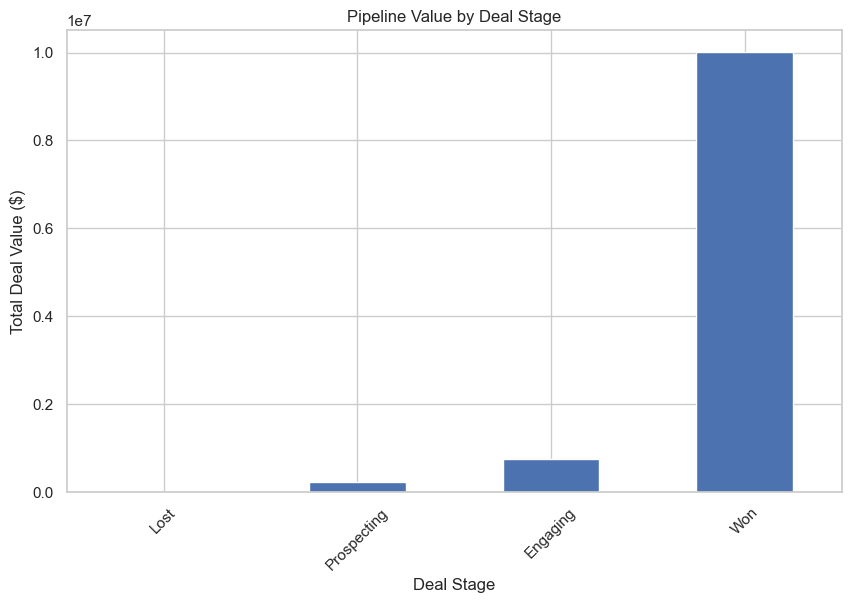

In [14]:
show_chart(
    chart_type="Pipeline by Stage",
    account=None,
    agent=None,
    timeframe=None
)

No Closed Won (revenue) data.


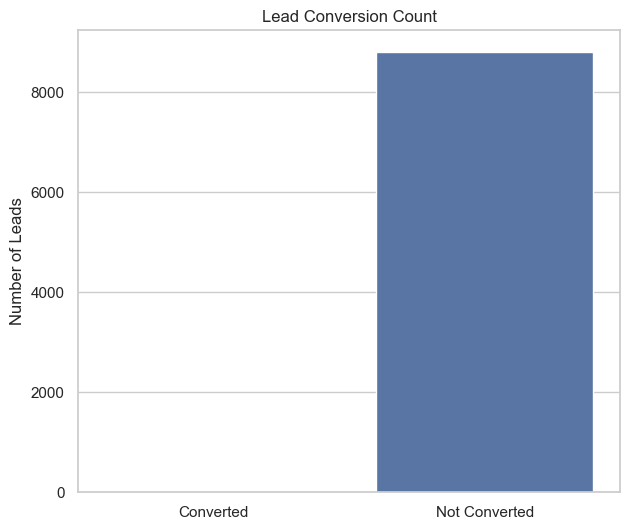

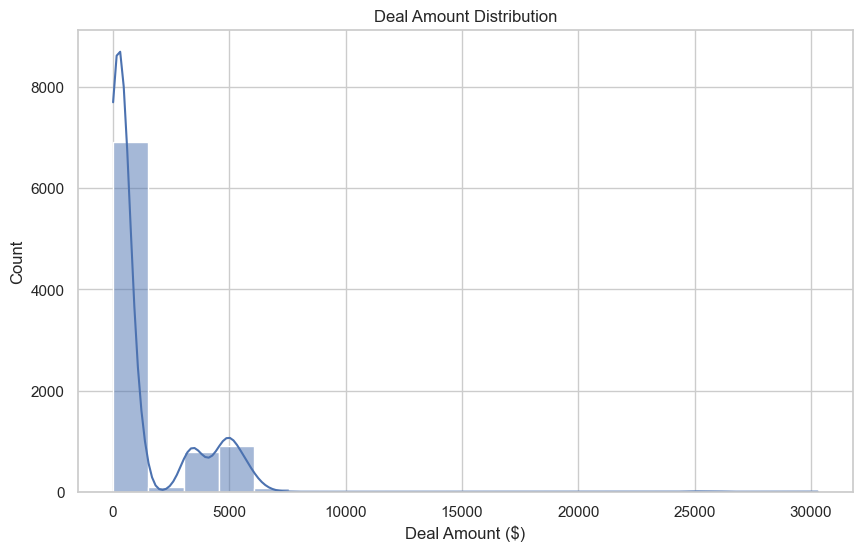

In [15]:
show_chart("Revenue by Industry")
show_chart("Lead Conversion")
show_chart("Deal Amount Distribution")
